In [1]:
import pandas as pd
import requests
from io import StringIO
import numpy as np
import certifi
import matplotlib.pyplot as plt
from prophet import Prophet

/Users/raihansukor/Downloads/School/DSA3101/subgroup-b/env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Define the Google Drive link and convert it to a direct download link
csv_url = 'https://drive.google.com/file/d/1GB-if5xcQM64dV4O6_H-HjcgOK21Z9j2/view?usp=sharing'
file_id = csv_url.split('/')[-2]
dwn_url = f'https://drive.google.com/uc?id={file_id}'

# Get the CSV data with SSL verification
response = requests.get(dwn_url, verify=certifi.where()).text

# Load the CSV content directly into a pandas DataFrame without saving it
csv_raw = StringIO(response)
data = pd.read_csv(csv_raw)

In [6]:
# Group data by date and filter by choice of StockCode
data['Invoice Date'] = pd.to_datetime(data['Invoice Date'])
stockcode = '84879' #random relatively high sales stockcode just to show how model works
daily_demand = data.groupby(['Invoice Date', 'StockCode'])['Quantity'].sum().reset_index()
product_data = daily_demand[daily_demand['StockCode'] == stockcode]

# Set index and resample to weekly data
product_data.set_index('Invoice Date', inplace=True)
weekly_sales = product_data['Quantity'].resample('W').sum().reset_index()
weekly_sales.columns = ['ds', 'y']  # Rename columns for Prophet

16:28:12 - cmdstanpy - INFO - Chain [1] start processing
16:28:12 - cmdstanpy - INFO - Chain [1] done processing


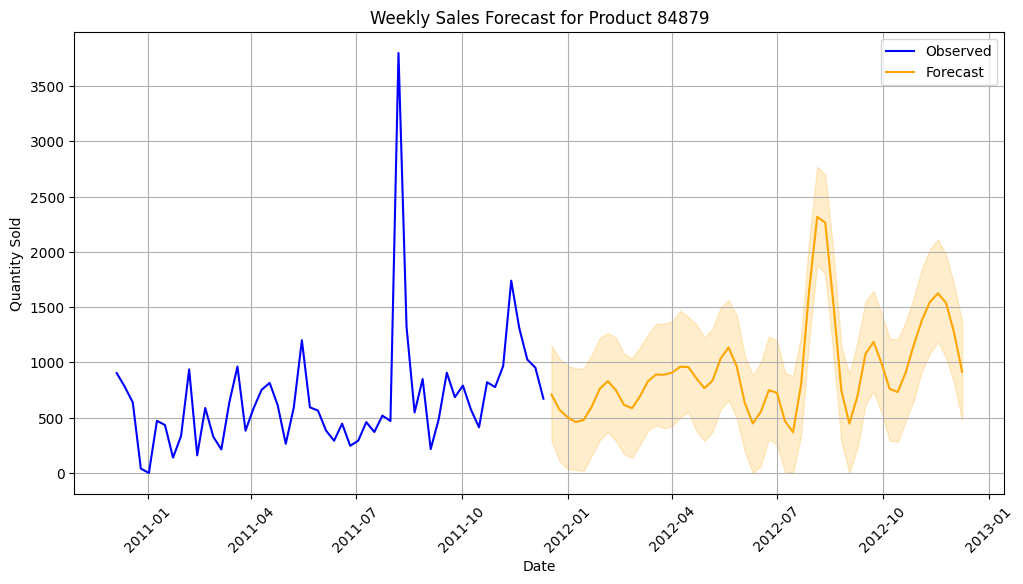

In [7]:
# Initialize and fit Prophet model on observed data
model_prophet = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
model_prophet.fit(weekly_sales)

# Create future dates for forecast (only beyond observed data)
future_dates = model_prophet.make_future_dataframe(periods=52, freq='W')
forecast_prophet = model_prophet.predict(future_dates)

# Calculate the bias based on the initial portion of the forecast vs the last observed values
observed_mean = weekly_sales['y'][-10:].mean()  # Average of the last 10 observed values
forecast_future_mean = forecast_prophet['yhat'][len(weekly_sales):].mean()  # Mean of the future forecasted values

# Calculate bias correction based on the difference
# prophet model takes into account the trend, which is upwards in this case
# this is undesirable in this scenario of sales since we only want to capture the seasonality/pattern
# Hence the need for bias correction 
bias = forecast_future_mean - observed_mean

# Apply bias correction only to the forecasted values after the observed period
forecast_prophet.loc[len(weekly_sales):, 'yhat_adjusted'] = (forecast_prophet.loc[len(weekly_sales):, 'yhat'] - bias).clip(lower=0)

# Plot observed data and adjusted forecast
plt.figure(figsize=(12, 6))
plt.plot(weekly_sales['ds'], weekly_sales['y'], label='Observed', color='blue')
plt.plot(forecast_prophet['ds'], forecast_prophet['yhat_adjusted'], label='Forecast', color='orange')
plt.fill_between(forecast_prophet['ds'], 
                 (forecast_prophet['yhat_lower'] - bias).clip(lower=0), 
                 (forecast_prophet['yhat_upper'] - bias).clip(lower=0), 
                 color='orange', alpha=0.2, where=(forecast_prophet['ds'] > weekly_sales['ds'].max()))
plt.title(f'Weekly Sales Forecast for Product {stockcode}')
plt.xlabel('Date')
plt.ylabel('Quantity Sold')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

In [8]:
# Extract the forecasted values from your Prophet model
forecasted_values = forecast_prophet[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

# Define inventory parameters
ordering_cost_per_order = 50  # Fixed cost per order
holding_cost_per_unit_per_week = 0.5  # Holding cost per unit per week
lead_time_weeks = 2  # Lead time in weeks

# Prepare lists to store dynamic inventory parameters for each forecasted period
eoq_list = []
safety_stock_list = []
rop_list = []

for i in range(len(forecasted_values)):
    # Forecasted demand for the week
    weekly_forecast = forecasted_values.loc[i, 'yhat']

    # Dynamic EOQ calculation based on forecasted demand
    eoq = np.sqrt((2 * weekly_forecast * ordering_cost_per_order) / holding_cost_per_unit_per_week)
    eoq_list.append(eoq)
    
    # Safety stock calculation using forecast confidence intervals
    # This accounts for variability in forecasted demand
    forecast_std_dev = (forecasted_values.loc[i, 'yhat_upper'] - forecasted_values.loc[i, 'yhat_lower']) / 2
    safety_stock = forecast_std_dev * np.sqrt(lead_time_weeks)
    safety_stock_list.append(safety_stock)
    
    # Dynamic Reorder Point (ROP)
    lead_time_demand = weekly_forecast * lead_time_weeks
    rop = lead_time_demand + safety_stock
    rop_list.append(rop)

# Add EOQ, Safety Stock, and ROP to forecasted data for analysis
forecasted_values['EOQ'] = eoq_list
forecasted_values['Safety_Stock'] = safety_stock_list
forecasted_values['ROP'] = rop_list

# Display the dynamic inventory parameters
forecasted_values[['ds', 'yhat', 'EOQ', 'Safety_Stock', 'ROP']]


/var/folders/3d/bcbm_tr93dq7wn1rs79_c2d80000gn/T/ipykernel_99731/271847439.py:19: RuntimeWarning: invalid value encountered in sqrt
  eoq = np.sqrt((2 * weekly_forecast * ordering_cost_per_order) / holding_cost_per_unit_per_week)
/var/folders/3d/bcbm_tr93dq7wn1rs79_c2d80000gn/T/ipykernel_99731/271847439.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecasted_values['EOQ'] = eoq_list
/var/folders/3d/bcbm_tr93dq7wn1rs79_c2d80000gn/T/ipykernel_99731/271847439.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

,ds,yhat,EOQ,Safety_Stock,ROP
0,2010-12-05,1002.843520,447.848975,658.163926,2663.850965
1,2010-12-12,656.813525,362.439933,622.802344,1936.429395
2,2010-12-19,414.140881,287.798847,657.635256,1485.917018
3,2010-12-26,294.689655,242.771355,627.036037,1216.415346
4,2011-01-02,232.270967,215.532349,651.211486,1115.753420
...,...,...,...,...,...
101,2012-11-11,1165.505210,482.805387,665.813583,2996.824003
102,2012-11-18,1242.649996,498.527832,654.539339,3139.839330
103,2012-11-25,1157.213647,481.084950,657.662528,2972.089822
104,2012-12-02,887.896642,421.401624,627.532353,2403.325637


## Interpretation
### Let's use values in row 102 as an example, where date 2012-11-11 and show how it guides inventory management decisions:

#### 1. ds (Date): 2012-11-11
- This is the forecasted week starting on November 11, 2012. All inventory decisions (ordering, safety stock, and reorder point) for this product apply to this particular week based on the forecasted demand.

#### 2. yhat (Forecasted Demand): 1165.51
- This is the forecasted quantity of the product expected to be sold in the week of November 11, 2012.
- This demand estimate helps plan the amount of stock needed to meet customer demand.

#### 3. EOQ (Economic Order Quantity): 482.81
- The EOQ of approximately 483 units represents the optimal order quantity that minimizes total inventory costs, balancing ordering and holding costs. Ordering this quantity minimizes costs in two ways:
  - **Ordering Costs:** By ordering 483 units, you avoid placing too many small, frequent orders, each of which incurs a fixed cost.
  - **Holding Costs:** Ordering only 483 units means you’re not holding excess inventory, which can incur holding costs over time.
- In this context, EOQ guides how many units to order each time inventory reaches the reorder point, optimizing the balance between having enough stock and minimizing carrying costs.

#### 4. Safety Stock: 628.23
- Safety stock is the additional buffer inventory (about 628 units) kept on hand to protect against variability in demand and lead time.
- This value is particularly useful if actual demand is higher than forecasted or if there are delays in receiving new stock. It helps avoid stockouts, ensuring product availability even when demand is unexpectedly high.
- Maintaining safety stock minimizes the risk of lost sales or customer dissatisfaction due to stockouts, albeit at a slightly increased holding cost.

#### 5. ROP (Reorder Point): 2959.24
- The reorder point (ROP) indicates when you should place a new order to replenish stock. In this case, when the inventory level drops to around 2959 units, it’s time to reorder. The ROP is calculated as:

<div align="center">

$$
\text{ROP} = \text{Lead Time Demand} + \text{Safety Stock}
$$

</div>


where lead time demand is the forecasted demand over the lead time period (in this case, based on a two-week lead time).
- ROP ensures that you reorder in time to receive stock before current inventory runs out, considering both expected demand during the lead time and unexpected fluctuations.

### Balancing Stock Levels and Costs
To balance stock levels and costs effectively:

- **Order in Batches of EOQ:** Order about 483 units whenever inventory reaches the ROP. This minimizes costs over time by reducing both ordering and holding costs.
- **Maintain Safety Stock:** Keep around 628 units as buffer stock, ensuring product availability and reducing the chance of stockouts despite demand fluctuations.
- **Monitor Inventory Levels:** When inventory falls to the ROP (2959 units), place an order for EOQ units to keep stock levels optimized.

By following this approach, we can balance costs (minimized by ordering EOQ) and availability (ensured by ROP and Safety Stock), helping meet demand while managing inventory expenses efficiently.